In [177]:
import numpy as np
from scipy import stats
import seaborn as sns

In [178]:
%matplotlib inline

In [4]:
np.set_printoptions(suppress=True)

In [63]:
def hyperprior_person():
    """
    Draw the mean and covariance matrix for the prior on the person parameters.
    """
    
    # Uniform correlation
    eig1 = np.random.uniform(low=0.0, high=3.0)
    eig2 = np.random.uniform(low=0.0, high=3.0-eig1)
    eig3 = 3 - eig1 - eig2
    corr = stats.random_correlation.rvs([eig1, eig2, eig3])
    
    # Stds.
    sds = stats.halfcauchy(loc=0, scale=1).rvs(3)
    
    cov = np.diag(sds) @ corr @ np.diag(sds)
    return cov


def prior_person(n_pers):
    """
    Draw the person engagement, ability, and working speeds.
    """
    
    # Draw a covariance matrix
    cov = hyperprior_person()
    
    # Generate data
    person_params = np.random.multivariate_normal([0., 0., 0.], cov, size=(n_pers))
    return {'phi': person_params[:, 0], 'tau': person_params[:, 1], 'theta': person_params[:, 2]}


def prior_item(n_items, sigma=10.):
    """
    Draws the items' engegement difficulty, difficulty and time offset.
    """
    
    # First component  - engagement difficulty    (iota)
    # Second component  - time offset             (beta) 
    # Third component - item difficulty           (b)
    item_params = np.random.multivariate_normal(mean=[0., 0., 0.], 
                                                cov=np.identity(3) * sigma, 
                                                size=n_items)
    return {'iota': item_params[:, 0], 'beta': item_params[:, 1], 'theta': item_params[:, 2]}


def prior_common():
    """Draws the common parameters - common mean, stds, guessing parameter."""
    
    
    c = np.random.beta(1., 1.)
    gammas = np.random.normal(size=3)
    beta_D = np.random.normal()
    sigma_D = stats.halfcauchy(loc=0, scale=1).rvs()
    sigma_E = stats.halfcauchy(loc=0, scale=1).rvs()
    return {'c': c, 'gammas': gammas, 'beta_D': beta_D, 'sigma_D': sigma_D, 'sigma_E': sigma_E}


def prior(n_pers=100, n_items=20):
    """Draws samples from all priors."""
    
    pers_params = prior_person(n_pers)
    item_params = prior_item(n_items)
    common_params = prior_common()
    return pers_params, item_params, common_params

In [192]:
def engagement(phi, iota):
    """
    Computes the engagement across examinees and items.
    """
    
    # Vectorize via broadcasting
    diff = phi[:, np.newaxis] - iota[np.newaxis, :]
    probs = np.exp(diff) / (1 + np.exp(diff))
    deltas = np.random.binomial(n=1, p=probs)
    return deltas

def response_time(beta, tau, d, sigma_E, sigma_D, beta_D):
    """Computes the response times."""

    diff_e = -tau[:, np.newaxis] + beta[np.newaxis, :] + beta_D
    rt_e = np.where(d, 0., 
                    stats.lognorm(s=sigma_E, scale=np.exp(diff_e)).rvs())
    rt_d = np.where(d, 
                    stats.lognorm(s=sigma_D, scale=np.exp(beta_D)).rvs(size=(diff_e.shape[0], diff_e.shape[1])), 0.)
    return diff_e

def response():
    pass
    
    
    
# def forward_model(n_pers=100, n_items=30):
#     """
#     Implements the generative SE+A model.
#     """

In [201]:
%%time
person_params, item_params, common_params = prior()
d = engagement(person_params['phi'], item_params['iota'])
rt = response_time(item_params['beta'], 
                   person_params['tau'], 
                   d, 
                   common_params['sigma_E'], 
                   common_params['sigma_D'],
                   common_params['beta_D'])   

Wall time: 15.8 ms


In [202]:
rt

array([[-0.94855337,  0.47713682, -3.78668015, ..., -2.44444467,
        -0.45721552, -6.86373263],
       [ 2.34097828,  3.76666848, -0.4971485 , ...,  0.84508698,
         2.83231614, -3.57420098],
       [ 0.12690765,  1.55259784, -2.71121913, ..., -1.36898365,
         0.6182455 , -5.78827161],
       ...,
       [ 2.22487483,  3.65056502, -0.61325195, ...,  0.72898353,
         2.71621268, -3.69030443],
       [-2.40950754, -0.98381735, -5.24763432, ..., -3.90539885,
        -1.91816969, -8.3246868 ],
       [ 0.1966282 ,  1.6223184 , -2.64149858, ..., -1.2992631 ,
         0.68796606, -5.71855106]])

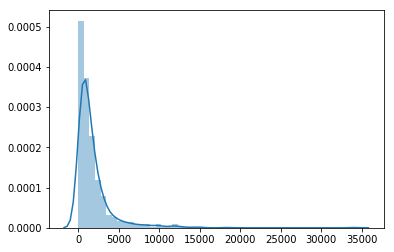

In [207]:
sns.distplot(np.random.lognormal(mean=7, size=1000))

In [188]:
np.random.lognormal(mean=2, size=5)

array([ 5.96235497, 30.25086124, 10.77811075, 31.04852288,  4.83012237])

In [112]:
np.where(d, np.random.lognormal(size=d.sum()), 0)

ValueError: operands could not be broadcast together with shapes (100,20) (760,) () 

In [ ]:
params['common'].shape

In [ ]:
r = response_time(params['person'][:, 1], params['item'][:, 1], d, params['common'][6])

In [160]:
stats.halfcauchy(loc=0, scale=1).rvs(3)

array([7.48307999, 3.01904841, 0.69157462])